In [45]:
#Necessary Libraries


import numpy as np
import tensorflow as tf
from random import randint
import matplotlib.pyplot as plt
from numpy import array,argmax,array_equal
import keras.backend as K
from tensorflow.keras import models,Input
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Bidirectional, SimpleRNN, GRU,Lambda,Dense, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.ticker as ticker
tf.keras.backend.set_floatx('float64')
from tensorflow.keras.layers import TimeDistributed,RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import FontProperties

In [46]:
!pip install imageio imageio -ffmpeg
!pip install tqdm

Looking in links: fmpeg


In [86]:
import imageio
import os   
from tqdm import tqdm_notebook as tqdm                                          #used for progress bar in loops
from PIL import Image
from IPython.display import HTML as html_print
from IPython.display import display

In [49]:
#Loading the dakshina dataset

!wget https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
!tar -xf dakshina_dataset_v1.0.tar

--2022-05-15 14:18:47--  https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.197.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008340480 (1.9G) [application/x-tar]
Saving to: ‘dakshina_dataset_v1.0.tar.1’

dakshina_dataset_v1 100%[===================>]   1.87G   252MB/s    in 7.7s    

2022-05-15 14:18:55 (249 MB/s) - ‘dakshina_dataset_v1.0.tar.1’ saved [2008340480/2008340480]



In [50]:
#Selecting the Hindi language

!ls dakshina_dataset_v1.0/hi/lexicons

hi.translit.sampled.dev.tsv   hi.translit.sampled.train.tsv
hi.translit.sampled.test.tsv


In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
!unzip /content/nirmala-ui.zip

Archive:  /content/nirmala-ui.zip
replace nirmala.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Nirmala.ttf? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace sharefonts.net.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [53]:
hindi_font=FontProperties(fname='/content/Nirmala.ttf')

In [54]:
hindi_font

In [55]:
#Directory for Training,Validation and Testing
train_dir = "./dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv"
val_dir = "./dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv"
test_dir = "./dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv"

In [56]:
# Reading the raw corpus
#returns the native(Hindi) and romanized(English) versions of the words in the corpus

import io
def raw_corpus(crp):
  Eng = []
  Hindi= []
  with io.open(crp, encoding ='utf-8') as f:
    for line in f:
      if '\t' not in line:
        continue
      tokens = line.rstrip().split("\t")
      Eng.append(tokens[1])
      Hindi.append(tokens[0])
  return Eng, Hindi 

In [57]:
train_src, train_tgt = raw_corpus(train_dir)
val_src, val_tgt = raw_corpus(val_dir)
test_src, test_tgt = raw_corpus(test_dir)

print("Training examples: ", len(train_src))
print("Validation examples: ", len(val_src))
print("Testing examples: ", len(test_src))

Training examples:  44204
Validation examples:  4358
Testing examples:  4502


In [58]:
ip_txt_ns = []
tgt_txt_ns = []
val_ip_txt_ns = []
val_tgt_txt_ns = []
ip_char = set()
tgt_char = set()

In [59]:
for (txt_ip, txt_tgt) in zip(train_src, train_tgt):
    # tab : "start sequence" character
    # \n  : "end sequence" character
    txt_tgt = "B" + txt_tgt + "E"
    ip_txt_ns.append(txt_ip)
    tgt_txt_ns.append(txt_tgt)

    for char in txt_ip:
        if char not in ip_char:
            ip_char.add(char)

    for char in txt_tgt:
        if char not in tgt_char:
            tgt_char.add(char)


for (txt_ip, txt_tgt) in zip(val_src, val_tgt):
    # tab : "start sequence" character
    # \n  : "end sequence" character
    txt_tgt = "B" + txt_tgt + "E"
    val_ip_txt_ns.append(txt_ip)
    val_tgt_txt_ns.append(txt_tgt)
    for char in txt_ip:
        if char not in ip_char:
            ip_char.add(char)
    for char in txt_tgt:
        if char not in tgt_char:
            tgt_char.add(char)

In [60]:
#Shuffling the Training and Validation dataset

train_arr = np.arange(len(train_src))
np.random.shuffle(train_arr)
val_arr = np.arange(len(val_src))
np.random.shuffle(val_arr)


In [61]:
ips_txt = []
tgts_txt = []

for i in range(len(train_src)):
    ips_txt.append(ip_txt_ns[train_arr[i]])
    tgts_txt.append(tgt_txt_ns[train_arr[i]])

In [62]:
val_ip_txt = []
val_tgt_txt = []

for i in range(len(val_src)):
    val_ip_txt.append(val_ip_txt_ns[val_arr[i]])
    val_tgt_txt.append(val_tgt_txt_ns[val_arr[i]])

In [63]:
ip_char.add(" ")
tgt_char.add(" ")
ip_char = sorted(list(ip_char))
tgt_char = sorted(list(tgt_char))

In [64]:
enc_tokens = len(ip_char)
dec_tokens= len(tgt_char)

In [65]:
max_enc_seq_length = max([len(txt) for txt in ips_txt])
max_dec_seq_length = max([len(txt) for txt in tgts_txt])
val_max_enc_seq_length = max([len(txt) for txt in val_ip_txt])
val_max_dec_seq_length = max([len(txt) for txt in val_tgt_txt])

In [66]:
ip_tk_idx= dict([(j, k) for k, j in enumerate(ip_char)])
tgt_tk_idx= dict([(j, k) for k, j in enumerate(tgt_char)])
rev_src_char_idx = dict((i, char) for char, i in ip_tk_idx.items())
rev_tgt_char_idx = dict((i, char) for char, i in tgt_tk_idx.items())

In [67]:
print(ip_tk_idx)
print(tgt_tk_idx)

{' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{' ': 0, 'B': 1, 'E': 2, 'ँ': 3, 'ं': 4, 'ः': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ए': 13, 'ऐ': 14, 'ऑ': 15, 'ओ': 16, 'औ': 17, 'क': 18, 'ख': 19, 'ग': 20, 'घ': 21, 'ङ': 22, 'च': 23, 'छ': 24, 'ज': 25, 'झ': 26, 'ञ': 27, 'ट': 28, 'ठ': 29, 'ड': 30, 'ढ': 31, 'ण': 32, 'त': 33, 'थ': 34, 'द': 35, 'ध': 36, 'न': 37, 'प': 38, 'फ': 39, 'ब': 40, 'भ': 41, 'म': 42, 'य': 43, 'र': 44, 'ल': 45, 'व': 46, 'श': 47, 'ष': 48, 'स': 49, 'ह': 50, '़': 51, 'ा': 52, 'ि': 53, 'ी': 54, 'ु': 55, 'ू': 56, 'ृ': 57, 'ॅ': 58, 'े': 59, 'ै': 60, 'ॉ': 61, 'ो': 62, 'ौ': 63, '्': 64, 'ॐ': 65}


In [68]:
trc_ip_txt = ips_txt[:44160]
trc_tgt_txt = tgts_txt[:44160]

In [69]:
ip_encd = np.zeros(
    (len(trc_ip_txt), max_enc_seq_length, enc_tokens), dtype="float64"
)
tgt_decd = np.zeros(
    (len(trc_ip_txt), max_dec_seq_length, dec_tokens), dtype="float64"
)

In [70]:
for i, (txt_ip, txt_tgt) in enumerate(zip(trc_ip_txt, trc_tgt_txt)):
    for m, n in enumerate(txt_ip):
        ip_encd[i, m, ip_tk_idx[n]] = 1.0
    ip_encd[i, m + 1 :, ip_tk_idx[" "]] = 1.0
    for m, n in enumerate(txt_tgt):
        tgt_decd[i, m, tgt_tk_idx[n]] = 1.0
    tgt_decd[i, m + 1 :, tgt_tk_idx[" "]] = 1.0

In [71]:
val_ip_encd= np.zeros(
    (len(val_ip_txt), max_enc_seq_length, enc_tokens), dtype="float64"
)
val_tgt_decd = np.zeros(
    (len(val_tgt_txt), max_dec_seq_length, dec_tokens), dtype="float64"
)

In [72]:
for i, (txt_ip, txt_tgt) in enumerate(zip(val_ip_txt, val_tgt_txt)):
    
    for t, n in enumerate(txt_ip):
        val_ip_encd[i, t, ip_tk_idx[n]] = 1.0
    val_ip_encd[i, t + 1 :, ip_tk_idx[" "]] = 1.0

    for t, n in enumerate(txt_tgt):
        val_tgt_decd[i, t, tgt_tk_idx[n]] = 1.0
    val_tgt_decd[i, t + 1: , tgt_tk_idx[" "]] = 1.0

In [73]:
class Bahdanau(tf.keras.layers.Layer):
  def __init__(self, units):
    super(Bahdanau, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
    
  def call(self, query, value):
    
    query_with_time_axis = tf.expand_dims(query, 1)
    
    score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(value)))
    
    aw = tf.nn.softmax(score, axis=1)
    vc = aw * value
    vc = tf.reduce_sum(vc, axis=1)

    return vc, aw

In [79]:
class Seq_to_Seq_with_attention(object):

  def __init__(self, cell = 'RNN', hidden_layer=32, learning_rate= 1e-3, drop_out = 0.3,
               epochs = 10, batch_size = 32, attention = 'bahdanau'):
    
    self.cell = cell
    self.hidden_layer = hidden_layer
    self.learning_rate = learning_rate
    self.drop_out = drop_out
    self.epochs = epochs
    self.batch_size = batch_size
    self.attention = attention

  def fit_model(self, ip_encd, tgt_decd):

    ip_encds = Input(shape=(max_enc_seq_length, enc_tokens), name='enc_inputs')

    if self.cell == 'LSTM':

      enc_lstm = LSTM(self.hidden_layer,return_sequences=True, return_state=True, dropout = self.drop_out, name='enc_lstm')
      enc_ops, enc_hs, enc_cs = enc_lstm(ip_encds)
      states_enc = [enc_hs, enc_cs]

    elif self.cell == 'RNN':

      enc_rnn = SimpleRNN(self.hidden_layer,return_sequences=True, return_state=True, dropout = self.drop_out, name='enc_rnn')
      enc_ops, enc_hs = enc_rnn(ip_encds)
      states_enc = [enc_hs]

    elif self.cell == 'GRU':

      enc_gru = GRU(self.hidden_layer,return_sequences=True, return_state=True, dropout = self.drop_out, name='enc_gru')
      enc_ops, enc_hs = enc_gru(ip_encds)
      states_enc = [enc_hs]

    

    # Attention Layer
    if self.attention == 'bahdanau':
      attention= Bahdanau(self.hidden_layer)

    # dec Layers
    inps_deco = Input(shape=(1, (dec_tokens + self.hidden_layer)),name='dec_inputs')

    if self.cell == 'LSTM':

      dec_lstm = LSTM(self.hidden_layer, dropout = self.drop_out, return_state=True, name='dec_lstm')
    
    elif self.cell == 'GRU':

      dec_gru = GRU(self.hidden_layer, dropout = self.drop_out, return_state=True, name='dec_gru')
    
    elif self.cell == 'RNN':

      dec_rnn = SimpleRNN(self.hidden_layer, dropout = self.drop_out, return_state=True, name='dec_rnn')  
    
    
    dec_dense = Dense(dec_tokens, activation='softmax',  name='dec_dense')
    all_ops = []

    ips = np.zeros((self.batch_size, 1, dec_tokens))
    ips[:, 0, 0] = 1 

    dec_ops = enc_hs
    states = states_enc

    for _ in range(max_dec_seq_length):

      vc, aw = attention(dec_ops, enc_ops)
      vc = tf.expand_dims(vc, 1)
      
      ips = tf.concat([vc, ips], axis=-1)

      if self.cell == 'LSTM':

        dec_ops, hs, cs = dec_lstm(ips, initial_state=states)

      if self.cell == 'GRU':

        dec_ops, hs = dec_gru(ips, initial_state=states)

      if self.cell == 'RNN':

        dec_ops, hs = dec_rnn(ips, initial_state=states)
      
      ops = dec_dense(dec_ops)
      ops = tf.expand_dims(ops, 1)
      all_ops.append(ops)
      ips = ops
      if self.cell == 'LSTM':

        states = [hs, cs]

      if self.cell == 'GRU' or self.cell == 'RNN':
        
        states = [hs]


    dec_ops = Lambda(lambda x: K.concatenate(x, axis=1))(all_ops)
    model = Model(ip_encds, dec_ops, name='model_enc_dec')
    
    optimizer = Adam(lr=self.learning_rate, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(ip_encd, tgt_decd,
              batch_size=self.batch_size, 
              epochs=self.epochs,
              #callbacks = [WandbCallback()]
              )
    
    if self.cell == 'LSTM':
      return enc_lstm,attention,dec_lstm,dec_dense
    if self.cell == 'GRU':
      return enc_gru,attention,dec_gru,dec_dense
    if self.cell == 'RNN':
      return enc_rnn,attention,dec_rnn,dec_dense  

  def evaluate(self,seq_in):
    attention_plot = np.zeros((max_dec_seq_length, max_enc_seq_length))

    sequence = seq_in

    enc_inputs=array(sequence).reshape(1,max_enc_seq_length,enc_tokens)
    
    enc_inputs = tf.convert_to_tensor(enc_inputs,dtype=tf.float32)
    
    if self.cell == 'LSTM':
      
      enc_outputs, enc_state_h, enc_state_c = encoder(enc_inputs)
      enc_states = [enc_state_h, enc_state_c]
    elif self.cell == 'GRU':
      enc_outputs, enc_state_h = encoder(enc_inputs)
      enc_states = [enc_state_h]

    elif self.cell == 'RNN':
      
      enc_outputs, enc_state_h = encoder(enc_inputs)
      enc_states = [enc_state_h]

    all_outputs = []

    dec_input_data = np.zeros((1, 1, dec_tokens))
    dec_input_data[:, 0, 0] = 1 

    inputs = dec_input_data
    dec_outputs = enc_state_h
    states = enc_states

    weigh_atten =[]
    for t in range(max_dec_seq_length):

      # pay attention
      context_vector, attention_weights=attention(dec_outputs, enc_outputs)

      # storing the attention weights to plot later on
      attention_weights = tf.reshape(attention_weights, (-1, ))
      weigh_atten.append(attention_weights)
      
      attention_plot[t] = attention_weights.numpy()
      
      dec_outputs=tf.expand_dims(dec_outputs, 1)

      context_vector = tf.expand_dims(context_vector, 1)
      inputs = tf.concat([context_vector, inputs], axis=-1)

      if self.cell == 'LSTM':
        dec_outputs, state_h, state_c = decoder(inputs, initial_state=states)
      if self.cell == 'GRU':
        dec_outputs, state_h = decoder(inputs, initial_state=states)
      if self.cell == 'RNN':
        dec_outputs, state_h = decoder(inputs, initial_state=states)
            
      outputs = decoder_dense(dec_outputs)
      # Store the current prediction (we will concatenate all predictions later)
      outputs = tf.expand_dims(outputs, 1)
      all_outputs.append(outputs)
      inputs = outputs
      if self.cell == 'LSTM':
        states = [state_h, state_c]
      if self.cell == 'GRU' or self.cell == 'RNN':
        states = [state_h]
    
    dec_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    seq_outs = dec_outputs[0]
    seq_out = tf.argmax(seq_outs, axis=1)
    seq_out = seq_out.numpy()
    seq_in = tf.argmax(seq_in, axis = 1)
    seq_in = seq_in.numpy()
    list(filter(lambda num: num != 0, seq_in))
    list(filter(lambda num: num != 0, seq_out))
    
    return seq_in, seq_out, attention_plot, weigh_atten

  def plot_attention(self,attention, sequence, predicted_sequence):
    
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 60}
    seq = ''
    for i in range(len(sequence)):
      seq = seq + rev_src_char_idx[sequence[i]]
    
    pred = ''
    for i in range(len(predicted_sequence)):
      pred = pred + rev_tgt_char_idx[predicted_sequence[i]]

    ax.set_xticklabels(seq, fontdict=fontdict)
    ax.set_yticklabels(pred, fontdict=fontdict, fontproperties =hindi_font)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
    
  def translate(self,seq_in):
    seq_in, seq_out, attention_plot, weigh_atten = self.evaluate(seq_in)

    a = [0]
    for i in range(len(seq_in)):
      if seq_in[i] != 0:
        a.append(seq_in[i])

    b = []
    for i in range(len(seq_out)):
      if seq_out[i] != 0:
        b.append(seq_out[i])
  
    b = b[:len(b)-1]
    print(a)
    print(b)
    
    attention_plot = attention_plot[:len(b), :len(a)]
    self.plot_attention(attention_plot, a, b)  

    return weigh_atten

  def attention_plot(self,val_input):

      seq_in = val_input
      aw = self.translate(seq_in)  
      return aw

    

In [81]:
rnn_model = Seq_to_Seq_with_attention(cell = 'LSTM', hidden_layer=128, learning_rate= 1e-3,
                        drop_out=0.2,epochs = 15, batch_size = 128, attention = 'bahdanau')

In [76]:
encoder,attention,decoder,decoder_dense = rnn_model.fit_model(ip_encd,tgt_decd)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
345/345 [==============================] - 61s 99ms/step - loss: 1.3194 - accuracy: 0.6805
Epoch 2/15
345/345 [==============================] - 34s 97ms/step - loss: 1.1315 - accuracy: 0.6995
Epoch 3/15
345/345 [==============================] - 33s 97ms/step - loss: 1.0542 - accuracy: 0.7133
Epoch 4/15
345/345 [==============================] - 33s 96ms/step - loss: 0.9776 - accuracy: 0.7253
Epoch 5/15
345/345 [==============================] - 33s 96ms/step - loss: 0.9186 - accuracy: 0.7365
Epoch 6/15
345/345 [==============================] - 33s 96ms/step - loss: 0.8749 - accuracy: 0.7471
Epoch 7/15
345/345 [==============================] - 33s 96ms/step - loss: 0.8384 - accuracy: 0.7557
Epoch 8/15
345/345 [==============================] - 33s 96ms/step - loss: 0.8060 - accuracy: 0.7633
Epoch 9/15
345/345 [==============================] - 34s 98ms/step - loss: 0.7787 - accuracy: 0.7695
Epoch 10/15
345/345 [==============================] - 33s 97ms/step - loss: 0.753

[0, 25, 15, 8, 1, 1, 14]
[1, 43, 62, 50, 52, 37]


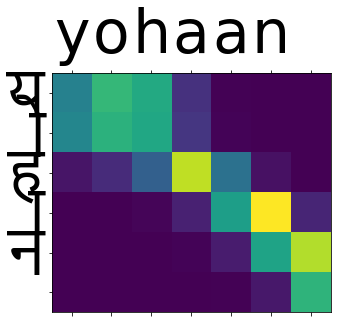

In [83]:
w_a = rnn_model.attention_plot(val_ip_encd[10])

In [84]:
def cstr(s, color='black'):
	if s == ' ':
		return "<text style=color:#000;padding-left:10px;background-color:{}> </text>".format(color, s)
	else:
		return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)
	
# print html
def print_color(t):
	display(html_print(''.join([cstr(ti, color=ci) for ti,ci in t])))

# get appropriate color for value
def get_clr(value):
	colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8'
		'#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
		'#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
		'#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
	value = int((value * 100) / 5)
	return colors[value]

In [85]:
english = [13, 19, 17, 6, 2, 7, 14, 19]
hindi = [21, 30, 42, 28, 12, 29, 18, 44]

eng_rev = ''
for i in range(len(english)):
  eng_rev = eng_rev + rev_src_char_idx[english[i]]

hindi_rev = ''
for i in range(len(hindi)):
  hindi_rev = hindi_rev + rev_tgt_char_idx[hindi[i]]

print(eng_rev) 
print(hindi_rev)

len_eng = len(english)
len_hindi = len(hindi)
print(len_eng)
print(len_hindi)

for i in range(len(hindi)):
  print(rev_tgt_char_idx[hindi[i]])

msqfbgns
घडमटऋठकर
8
8
घ
ड
म
ट
ऋ
ठ
क
र


In [87]:
def visualize(ov, res,idx):
  #print("\nCell Number:", cell_no, "\n")
  tc = []
  for i in range(len_eng):
    txt = (res[i], get_clr(ov[i]))
    tc.append(txt)
    if i == len_eng-1:
      hf= open(str(idx) + ".html", "w")
      hf.write(''.join([cstr(m,color=n) for m,n in tc]))
      hf.close()
      display(html_print(''.join([cstr(m,color=n) for m,n in tc])))

In [88]:
for i in range(len_hindi):
    visualize(w_a[i][:],eng_rev,i)